###1.скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
####там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
###2.сделать разбиение набора данных не тренировочную и тестовую выборки
###3.сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
###4.провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
###в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv("./data.csv")
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True )

In [4]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [5]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [6]:
indices_learn, indices_valid = train_test_split(df.index, test_size = 0.2, random_state = 42)

In [7]:
cat_col = ['zip_code', 'channel']
feature_col = ['recency', 'history']

In [8]:
one_hot = pd.get_dummies(df[cat_col])
df = df.drop(cat_col, axis=1)
df = df.join(one_hot)

In [9]:
scaler = StandardScaler()

df_norm = df.copy()
df[feature_col] = scaler.fit_transform(df_norm[feature_col])

In [10]:
df.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,1,0,0,0,0,1
2,0.352457,-0.239836,0,1,1,1,0,0,1,0,0,0,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               64000 non-null  float64
 1   history               64000 non-null  float64
 2   used_discount         64000 non-null  int64  
 3   used_bogo             64000 non-null  int64  
 4   is_referral           64000 non-null  int64  
 5   treatment             64000 non-null  int64  
 6   target                64000 non-null  int64  
 7   zip_code_Rural        64000 non-null  uint8  
 8   zip_code_Surburban    64000 non-null  uint8  
 9   zip_code_Urban        64000 non-null  uint8  
 10  channel_Multichannel  64000 non-null  uint8  
 11  channel_Phone         64000 non-null  uint8  
 12  channel_Web           64000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 3.8 MB


In [12]:
X_train = df.loc[indices_learn, :].drop(["treatment", "target"] , axis=1)
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(["treatment", "target"] , axis=1)
y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### Uplift-моделирование с признаком коммуникации (S learner)

In [ ]:
!pip install scikit-uplift catboost

In [14]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [15]:
from catboost import CatBoostClassifier

uplift@10%: 0.1060
uplift@20%: 0.0994


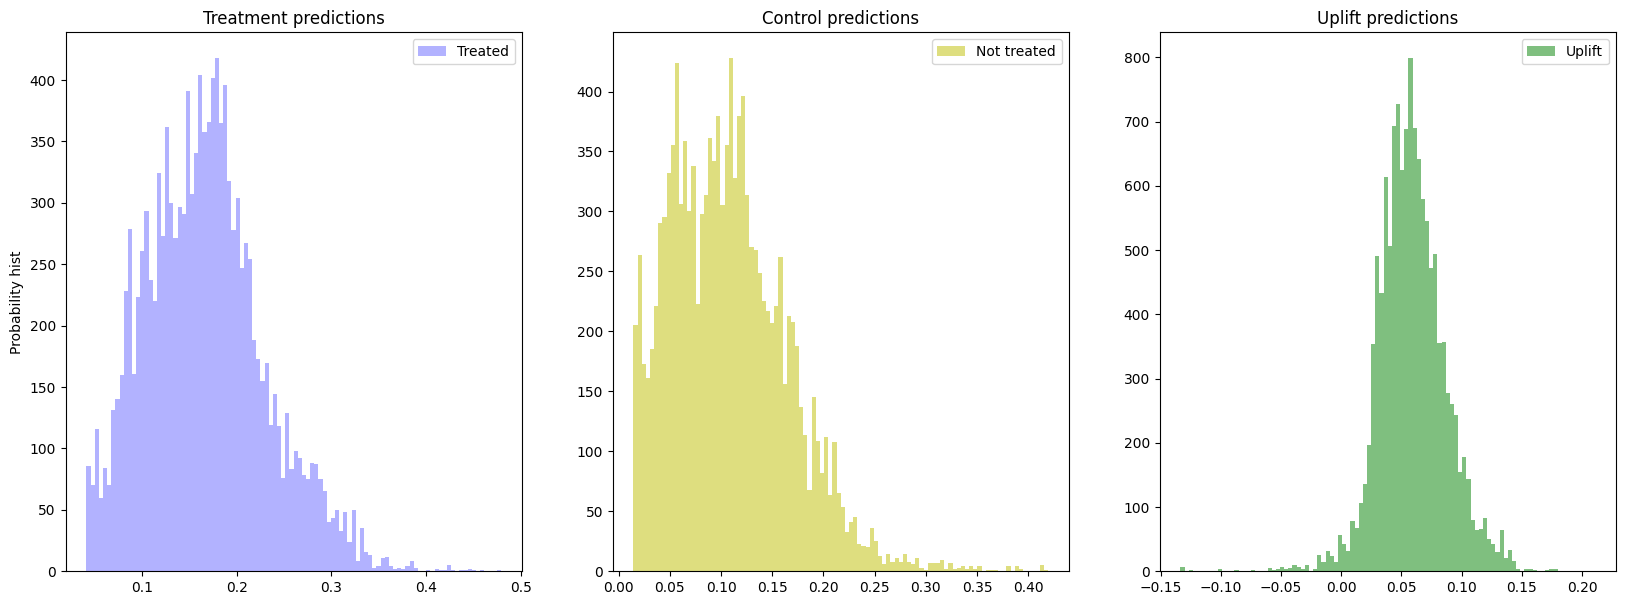

In [16]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)


print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')


# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);



Посмотрим на топ-признаки

In [17]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.944470
1,treatment,15.766042
2,recency,15.121068
3,history,14.804701
4,used_bogo,9.378633
5,used_discount,6.486860
6,channel_Web,6.440610
7,zip_code_Rural,5.845293
8,zip_code_Urban,2.367922
9,channel_Phone,2.185204


#### Uplift-моделирование с трансформацией таргета

In [18]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')

uplift@10%: 0.1097
uplift@20%: 0.0968


###Uplift-моделирование с двумя независимыми моделями

uplift@10%: 0.0918
uplift@20%: 0.0983


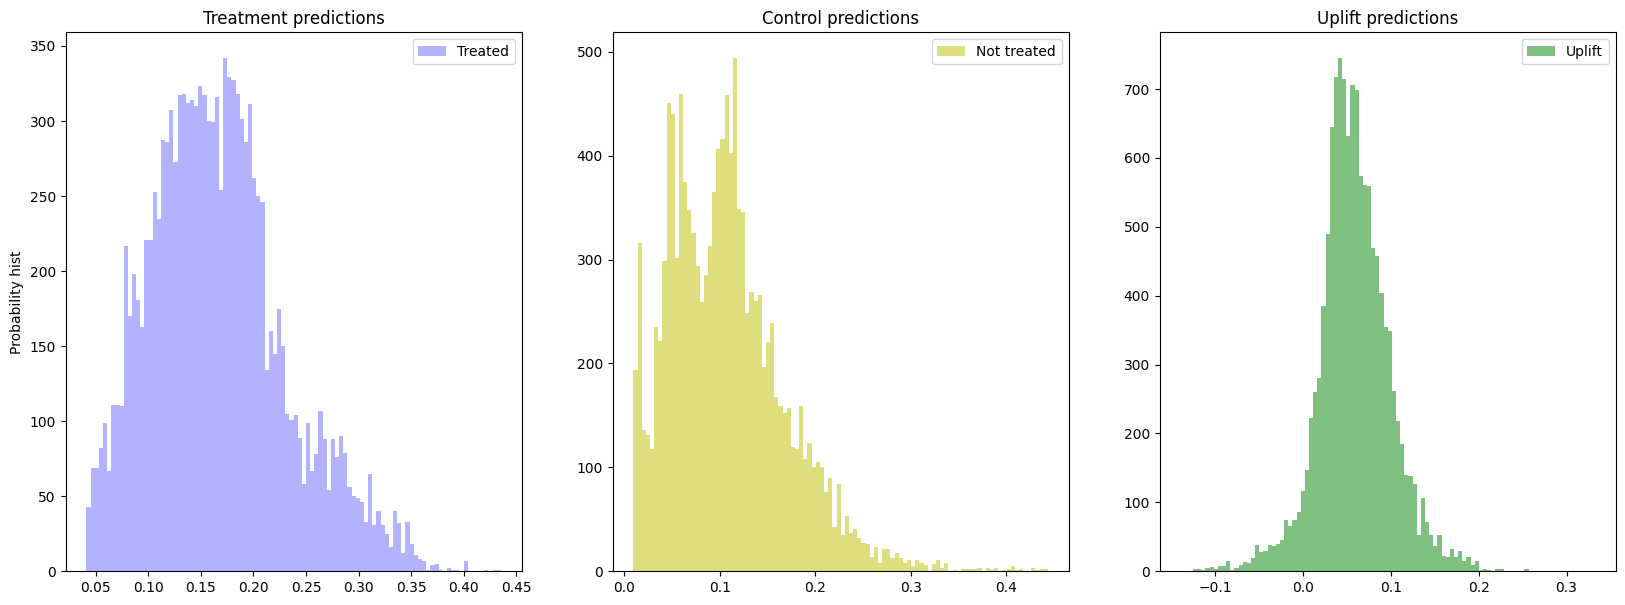

In [19]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [20]:
all_results = pd.DataFrame({
    'approach':['SoloModel', 'ClassTransformation', 'TwoModels'],
    'uplift@10%': [sm_score_10, ct_score_10, tm_score_10],
    'uplift@20%': [sm_score_20, ct_score_20, tm_score_20]
})

all_results

,approach,uplift@10%,uplift@20%
0,SoloModel,0.106022,0.099443
1,ClassTransformation,0.109683,0.096761
2,TwoModels,0.091817,0.098316


###При использовании стратегии "by_group" (где объекты разбиваются на группы на основе прогнозов эффекта воздействия) и оценке наилучшего эффекта воздействия на топ 10% объектов приводит к наилучшему результату положительного изменения поведения при Uplift-моделировании с трансформацией таргета, а при оценке наилучшего эффекта воздействия на топ 20% объектов приводит к наилучшему результату положительного изменения поведения при Uplift-моделировании с признаком коммуникации (S learner).